# JHU Sibley Hospital Phantom Scanning Test Protocol

**This is a methods notebook and should be moved to methods folder when convenient**

## Background and Motivation
Our simulation work has shown that adult-trained deep learning denoisers perform poorly when used on pediatric-sized patients with pediatric protocols. 1 A key contributor to this reduced performance was that the lower spatial frequency noise textures in pediatric protocols, due to their smaller FOV-size, were not present in the adult-trained denoising model’s training dataset. A follow-up study then found that by sampling noise textures from pediatric protocol phantom scans could be incorporated into model training via data augmentation techniques to regain performance in pediatric-sized patients.
The goal of this present study is to validate these (2) simulated findings using physical phantom scans on clinical scanners:

1. Deep learning denoising models trained on adult patient data perform well on adult-sized (large reconstructed FOVs) but poorly on pediatric (abdomen) protocol images with small body-fitting ROIs
2. Models trained with noise texture augmentation (described above) maintain more consistent denoising performance across patient and FOV size compared to baseline models

Performance will be assessing using objective measures of image quality described in the IEC CT Acceptance Testing standard,2 task-based assessment of low contrast detectability,3 and assessments of pediatric size-based generalizability.1
Physicist Dr. Tom Hrinivich at Sibley Hospital Proton Center, a collaborator on Rongping Zeng’s RO1 will be assisting us in performing phantom scans to validate some of our denoising methods.
The proposed testing protocol aims to reproduce the acquisition and reconstruction parameters used in constructing the Low-dose CT Grand Challenge Dataset (described in further detail below) while also adding different reconstructed fields of view reflective of the differences that exist between adult and pediatric CT protocols (details of reference adult and pediatric chest protocols are provided below as well).


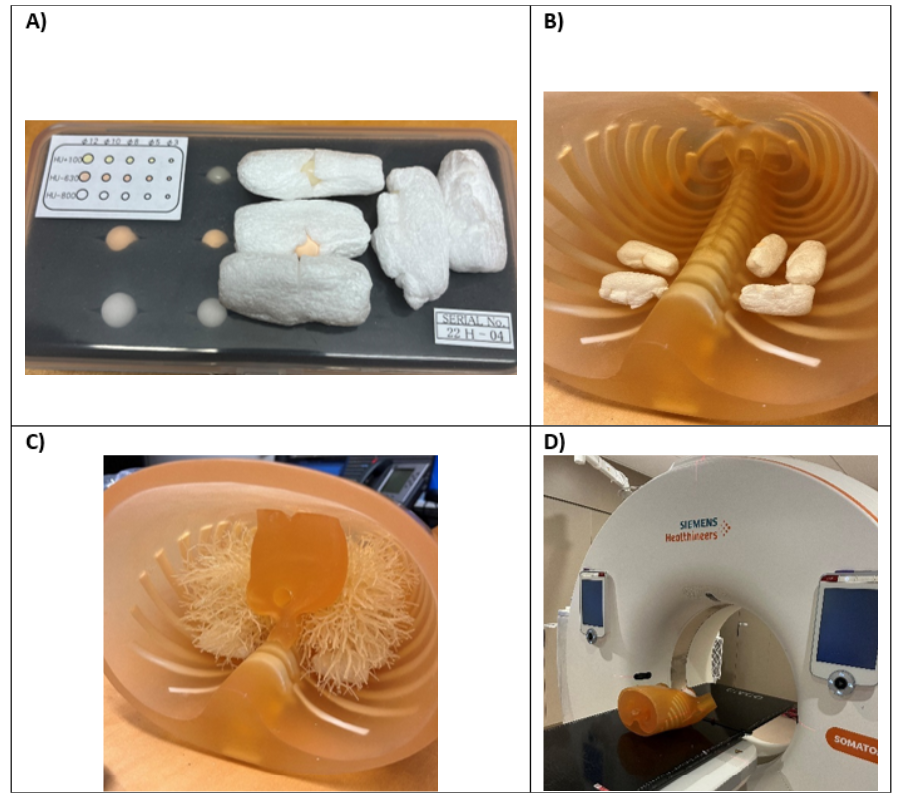

In [1]:
!ls /gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/Sibley\ Hospital\ Data/fbp/

ACR464	pediatric_chest_phantom


In [2]:
from pathlib import Path
import pandas as pd
import pydicom

In [3]:
base_dir = Path('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation')
data_dir = base_dir / 'Sibley Hospital Data'

## Organizing the data into a database
Start by organizing the data into a database to make it easier to work with, similar to what we did with the sims

In [4]:
pd.read_csv(base_dir/'CCT189_peds/metadata.csv').head()

,Name,effective diameter (cm),FOV (cm),recon,phantom,simulated,file,Dose [%]
0,35.0 cm MITA-LCD,35.0,39,RED-CNN augmented,MITA-LCD,True,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,10
1,35.0 cm MITA-LCD,35.0,39,RED-CNN,MITA-LCD,True,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,10
2,35.0 cm MITA-LCD,35.0,39,fbp,MITA-LCD,True,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,10
3,35.0 cm MITA-LCD,35.0,39,RED-CNN augmented,MITA-LCD,True,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,40
4,35.0 cm MITA-LCD,35.0,39,RED-CNN,MITA-LCD,True,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,40


In [5]:
import sys
sys.path.append('..')
from utils import make_metadata

metadata_filename = data_dir/'metadata.csv'

if not metadata_filename.exists():
    metadata = make_metadata(data_dir)
    metadata.to_csv(data_dir/'metadata.csv', index=False)
    
metadata = pd.read_csv(data_dir/'metadata.csv')
metadata.file = metadata.file.apply(lambda o: data_dir/o)
metadata

,Name,effective diameter (cm),FOV (cm),Dose [%],recon,kernel,phantom,repeat,file,slice,simulated
0,ACR464 FullMAs1 Br32 150mm RED-CNN,20.0,15.0,100,RED-CNN,Br32,ACR464,0,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,0,False
1,ACR464 FullMAs1 Br32 150mm RED-CNN,20.0,15.0,100,RED-CNN,Br32,ACR464,0,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,1,False
2,ACR464 FullMAs1 Br32 150mm RED-CNN,20.0,15.0,100,RED-CNN,Br32,ACR464,0,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,2,False
3,ACR464 FullMAs1 Br32 150mm RED-CNN,20.0,15.0,100,RED-CNN,Br32,ACR464,0,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,3,False
4,ACR464 FullMAs1 Br32 150mm RED-CNN,20.0,15.0,100,RED-CNN,Br32,ACR464,0,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,4,False
...,...,...,...,...,...,...,...,...,...,...,...
188419,pediatric_chest_phantom QuarterMAs1 Qr43 380mm...,27.2,38.0,25,fbp,Qr43,pediatric_chest_phantom,0,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,656,False
188420,pediatric_chest_phantom QuarterMAs1 Qr43 380mm...,27.2,38.0,25,fbp,Qr43,pediatric_chest_phantom,0,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,657,False
188421,pediatric_chest_phantom QuarterMAs1 Qr43 380mm...,27.2,38.0,25,fbp,Qr43,pediatric_chest_phantom,0,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,658,False
188422,pediatric_chest_phantom QuarterMAs1 Qr43 380mm...,27.2,38.0,25,fbp,Qr43,pediatric_chest_phantom,0,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,659,False


## Looking at the Data

In [6]:
metadata.repeat.unique()

array([0, 1, 2, 3, 4])

In [7]:
metadata['FOV (cm)'].unique()

array([15., 25., 38.])

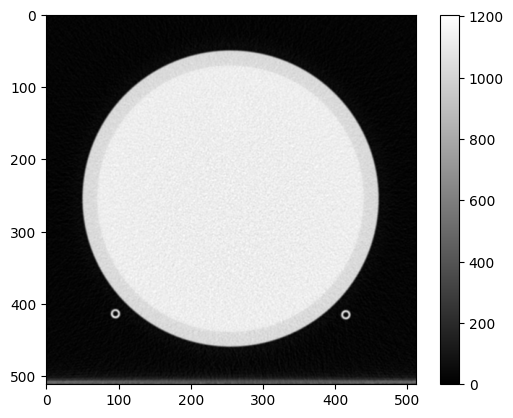

In [8]:
import matplotlib.pyplot as plt

row = metadata[(metadata['Dose [%]']==200) &
               (metadata['phantom'] == 'ACR464') &
               (metadata['recon'] == 'fbp') &
               (metadata['kernel'] == 'Qr43') &
               (metadata['FOV (cm)'] == 25) &
               (metadata['repeat'] == 0) &
               (metadata['slice'] == 251)]
dcm_file = row.file.item()

dcm = pydicom.dcmread(dcm_file)
img = dcm.pixel_array
plt.imshow(img, cmap='gray')
plt.colorbar()

Make presets for basic display settings: bone, lung, brain, soft tissue

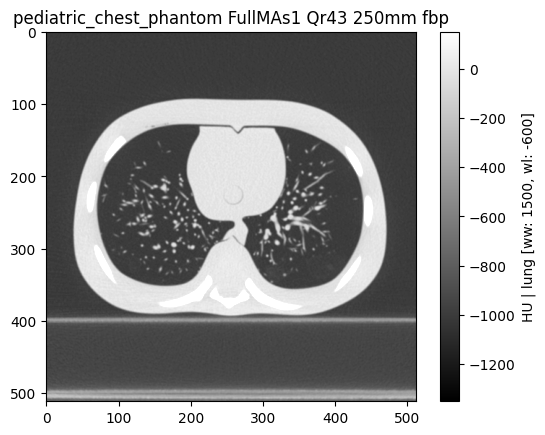

In [9]:
from utils import browse_studies
browse_studies(metadata,
               phantom='pediatric_chest_phantom',
               fov=25,
               dose=100,
               recon='fbp',
               kernel='Qr43',
               display='lung',
               slice_idx=367)

In [10]:
from utils import study_viewer

study_viewer(metadata)

interactive(children=(Dropdown(description='phantom', options=('ACR464', 'pediatric_chest_phantom'), value='AC…

## Preprocess Data for Analysis

Now do same ROI std measures for noise reduction in the noise module of the ACR phantom and append to `results.csv`

To be able to do this and merge this dataset into [denoising efficiency.ipynb](denoising%20efficiency.ipynb), I'll need to filter the dataframe down to just the slice containing the uniformity and noise portion (section 3 from [The phantom portion of the American College of Radiology (ACR) Computed Tomography (CT) accreditation program: Practical tips, artifact examples, and pitfalls to avoid](https://aapm.onlinelibrary.wiley.com/doi/10.1118/1.1769632). Based on our scans, this looks to be between slices `160`-`185` in the `ACr464` phantom

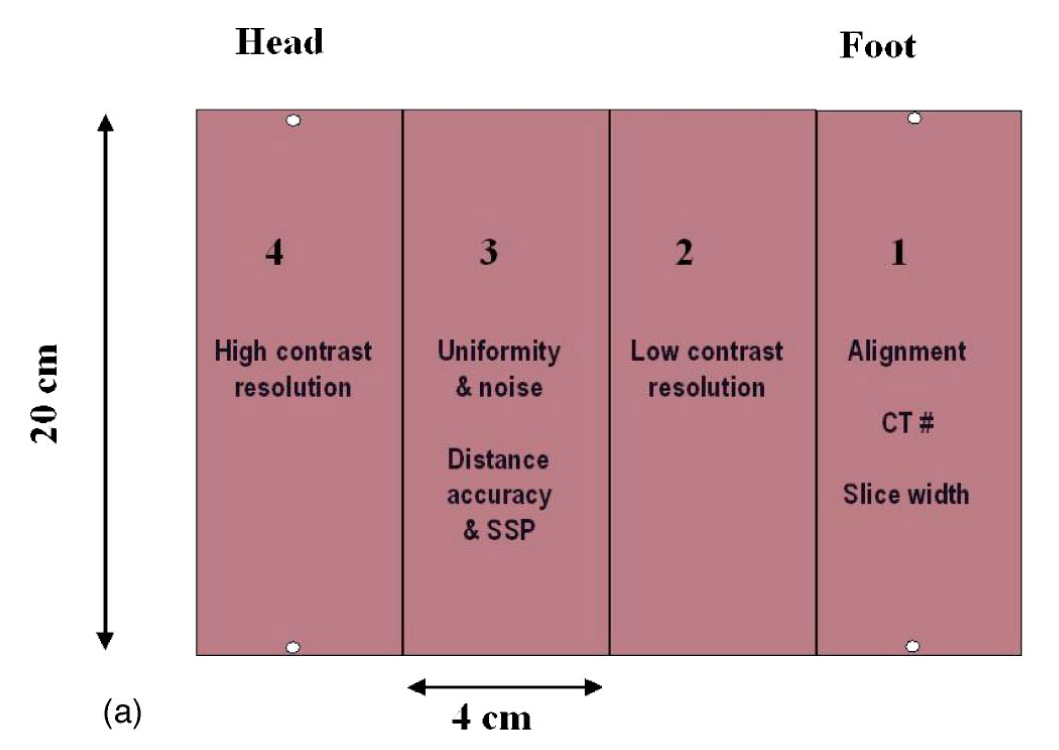

In [11]:
metadata[(metadata['phantom'] == 'ACR464') &
         ((metadata['slice'] > 159) & (metadata['slice'] < 186))
        ]

,Name,effective diameter (cm),FOV (cm),Dose [%],recon,kernel,phantom,repeat,file,slice,simulated
160,ACR464 FullMAs1 Br32 150mm RED-CNN,20.0,15.0,100,RED-CNN,Br32,ACR464,0,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,160,False
161,ACR464 FullMAs1 Br32 150mm RED-CNN,20.0,15.0,100,RED-CNN,Br32,ACR464,0,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,161,False
162,ACR464 FullMAs1 Br32 150mm RED-CNN,20.0,15.0,100,RED-CNN,Br32,ACR464,0,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,162,False
163,ACR464 FullMAs1 Br32 150mm RED-CNN,20.0,15.0,100,RED-CNN,Br32,ACR464,0,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,163,False
164,ACR464 FullMAs1 Br32 150mm RED-CNN,20.0,15.0,100,RED-CNN,Br32,ACR464,0,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,164,False
...,...,...,...,...,...,...,...,...,...,...,...
160312,ACR464 QuarterMAs5 Qr43 380mm fbp,20.0,38.0,25,fbp,Qr43,ACR464,4,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,181,False
160313,ACR464 QuarterMAs5 Qr43 380mm fbp,20.0,38.0,25,fbp,Qr43,ACR464,4,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,182,False
160314,ACR464 QuarterMAs5 Qr43 380mm fbp,20.0,38.0,25,fbp,Qr43,ACR464,4,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,183,False
160315,ACR464 QuarterMAs5 Qr43 380mm fbp,20.0,38.0,25,fbp,Qr43,ACR464,4,/gpfs_projects/brandon.nelson/PediatricCTSizeD...,184,False


sort into the correct directory structure of the project and save as metaheader files for common access in [denoising efficiency.ipynb](denoising%20efficiency.ipynb)

```
phantom /
        / diameter /
                    / sa, sp
                            / dose /
                                   / recon
```

In [12]:
import SimpleITK as sitk
import numpy as np

import os

from utils import load_mhd, concatenate_files_to_volumes, convert_dicom_to_metaheader, load_dicom

In [13]:
data_dir
preprocessed_dir = base_dir / 'ACR464'

In [14]:
preprocess_metadata_filename = preprocessed_dir / 'metadata.csv'

In [15]:
if not preprocess_metadata_filename.exists():
    preprocessed_metadata = convert_dicom_to_metaheader(metadata, phantom='ACR464')
    preprocessed_metadata = concatenate_files_to_volumes(preprocessed_metadata)
    preprocessed_metadata = preprocessed_metadata.sort_values(by=['recon', 'Dose [%]', 'FOV (cm)'], ascending=False).reset_index(drop=True)
    preprocessed_metadata.to_csv(preprocessed_dir / 'metadata.csv', index=False)
preprocessed_metadata = pd.read_csv(preprocess_metadata_filename)
preprocessed_metadata

,Name,effective diameter (cm),FOV (cm),Dose [%],recon,kernel,phantom,file
0,ACR464 HighMAs Br32 380mm fbp,20.0,38.0,200,fbp,Br32,ACR464,diameter200mm/fov380mm/dose_200/Br32/fbp/ACR46...
1,ACR464 HighMAs Qr43 380mm fbp,20.0,38.0,200,fbp,Qr43,ACR464,diameter200mm/fov380mm/dose_200/Qr43/fbp/ACR46...
2,ACR464 HighMAs Br32 250mm fbp,20.0,25.0,200,fbp,Br32,ACR464,diameter200mm/fov250mm/dose_200/Br32/fbp/ACR46...
3,ACR464 HighMAs Qr43 250mm fbp,20.0,25.0,200,fbp,Qr43,ACR464,diameter200mm/fov250mm/dose_200/Qr43/fbp/ACR46...
4,ACR464 HighMAs Br32 150mm fbp,20.0,15.0,200,fbp,Br32,ACR464,diameter200mm/fov150mm/dose_200/Br32/fbp/ACR46...
5,ACR464 HighMAs Qr43 150mm fbp,20.0,15.0,200,fbp,Qr43,ACR464,diameter200mm/fov150mm/dose_200/Qr43/fbp/ACR46...
6,ACR464 FullMAs1 Br32 380mm fbp,20.0,38.0,100,fbp,Br32,ACR464,diameter200mm/fov380mm/dose_100/Br32/fbp/ACR46...
7,ACR464 FullMAs1 Qr43 380mm fbp,20.0,38.0,100,fbp,Qr43,ACR464,diameter200mm/fov380mm/dose_100/Qr43/fbp/ACR46...
8,ACR464 FullMAs1 Br32 250mm fbp,20.0,25.0,100,fbp,Br32,ACR464,diameter200mm/fov250mm/dose_100/Br32/fbp/ACR46...
9,ACR464 FullMAs1 Qr43 250mm fbp,20.0,25.0,100,fbp,Qr43,ACR464,diameter200mm/fov250mm/dose_100/Qr43/fbp/ACR46...


In [16]:
test_fname = preprocessed_dir / preprocessed_metadata[preprocessed_metadata['Dose [%]']==100].iloc[0].file
vol = load_mhd(test_fname)
vol.shape

(130, 512, 512)

In [17]:
from utils import get_ground_truth
test_gt_fname = get_ground_truth(test_fname)
if not test_gt_fname.exists():
    estimate_ground_truth(preprocessed_metadata)